# Prediction of trends using LSTM

> Train: 2020.01.01~2020.12.31

> Test: 2021.1.1~2021.10.31

In [38]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from IPython.display import display
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
from itertools import cycle


## Prepare the data

In [3]:
# train_df = pd.read_pickle('22mdata.train.pkl')
# test_df = pd.read_pickle('22mdata.test.pkl')
df_nor = pd.read_pickle('22mnewsmoco.pkl')
df_nor.set_index(['dt'])
dateSepVal = pd.to_datetime('2020-12-31')
train_df = df_nor[df_nor['dt'] <= dateSepVal]
test_df = df_nor[df_nor['dt'] > dateSepVal]

num_features = train_df.shape[1] - 3
window_size = 5

display("%d rows for training and %d rows for test, features: %d" % (train_df.shape[0], test_df.shape[0], num_features))

'1042322 rows for training and 932087 rows for test, features: 7'

In [5]:
print(df_nor['emb'].count())
print(df_nor['emb'].count() / df_nor.shape[0])

1208704
0.612185215930438


### Group by stock codes

In [3]:
train_df_grouped = [x for _, x in train_df.groupby('kdcode')]
test_df_grouped = [x for _, x in test_df.groupby('kdcode')]



### Prepare for SLTM

In [135]:
class TimeSeriesDataSet(Dataset):
  def _flat_embs(self, b):
    embs = b[:, -2]
    embs = list(map(lambda x: np.zeros(self.feat_dim) if x is None else x, embs))
    embs = np.array(embs)
    return np.hstack((b[:, :-2], embs, b[:, -1:]))

  def __init__(self, data, window_size):
    df_grouped = [x for _, x in data.groupby('kdcode') if len(x) > window_size]
    self.df_grouped = df_grouped
    self.window_size = window_size
    self.sequence_length = window_size + 1
    for i in data['emb']:
      if i is not None:
        self.feat_dim = i.shape[0]
        break

  def __len__(self):
    return len(self.df_grouped)

  def __getitem__(self, index):
    data = []
    stock = self.df_grouped[index]
    stock = np.array(stock)
    stock = self._flat_embs(stock)
    for i in range(len(stock) - self.window_size):
        data.append(stock[i:i + self.sequence_length])
    
    data = np.array(data)
    X = data[:, :-1, 2:-1]
    Y = data[:, -1, -1]

    X = X.astype('float32')
    Y = Y.astype('float32')

    return X, Y

In [136]:
train_dataset = TimeSeriesDataSet(train_df, window_size)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = iter(cycle(DataLoader(TimeSeriesDataSet(test_df, window_size), batch_size=1, shuffle=False)))

## Build the Model

In [137]:
import torch.nn as nn
import torch
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fc_output_size, dropout):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, fc_output_size)
        self.activation = nn.ReLU()
        self.fc_1 = nn.Linear(fc_output_size, 1)

    def forward(self, input):
        lstm_out, _ = self.lstm1(input)
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        out = self.activation(out)
        out = self.fc_1(out)
        return out

## Train

In [143]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
num_epochs = 30
learning_rate = 0.002
input_size = train_dataset.feat_dim + 6
rnn = RNN(input_size, 50, 1, 16, 0.2)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    # acc = correct_results_sum/y_test.shape[0]
    acc = correct_results_sum
    return acc.item()

rnn = rnn.to(device)

history = []

for epoch in range(num_epochs):
    total_loss = 0
    total_test_loss = 0
    total_acc = 0
    total_test_acc = 0
    num_test = 0
    num_train = 0
    for (batch_idx, batch) in enumerate(train_loader):
        optimizer.zero_grad()
        bt_x_train, bt_y_train = batch
        bt_x_train = bt_x_train[0]
        bt_y_train = bt_y_train[0]
        num_train += bt_x_train.shape[0]
        x = bt_x_train.float()
        y = torch.Tensor(bt_y_train).float()
        bt_x_test, bt_y_test = next(test_loader)
        bt_x_test = bt_x_test[0]
        bt_y_test = bt_y_test[0]
        num_test += bt_x_test.shape[0]
        x_test = bt_x_test.float()
        y_test = torch.Tensor(bt_y_test).view(-1, 1).float()
        y = y.view(len(y), 1)
        x = x.to(device)
        y = y.to(device)
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        output = rnn(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        acc = binary_acc(output, y)
        output_test = rnn(x_test)
        test_loss = criterion(output_test, y_test)
        test_acc = binary_acc(output_test, y_test)
        total_loss += loss.item()
        total_test_loss += test_loss.item()
        total_acc += acc
        total_test_acc += test_acc
    #print("Epoch: %d, Loss: %f, Acc: %f, Test loss: %f, Test acc: %f" % (epoch+1, loss.item(), acc, test_loss, test_acc))
    #history.append([loss.item(), acc, test_loss.item(), test_acc.item()])
    total_loss = total_loss / num_train
    total_test_loss = total_test_loss / num_test
    total_acc = total_acc / num_train
    total_test_acc = total_test_acc / num_test
    print("Epoch: %d, Loss: %f, Acc:%f, Test loss: %f, Test acc: %f" % (epoch+1, total_loss, total_acc, total_test_loss, total_test_acc))
    history.append([total_loss, total_acc, total_test_loss, total_test_acc])

Epoch: 1, Loss: 0.684461, Acc:0.565037, Test loss: 1.005776, Test acc: 0.459142
Epoch: 2, Loss: 0.670265, Acc:0.567743, Test loss: 0.733088, Test acc: 0.521941
Epoch: 3, Loss: 0.663211, Acc:0.573755, Test loss: 0.659858, Test acc: 0.565587
Epoch: 4, Loss: 0.662176, Acc:0.576167, Test loss: 0.670539, Test acc: 0.570154
Epoch: 5, Loss: 0.660278, Acc:0.577870, Test loss: 0.627459, Test acc: 0.590843
Epoch: 6, Loss: 0.660114, Acc:0.579722, Test loss: 0.646262, Test acc: 0.584673
Epoch: 7, Loss: 0.658023, Acc:0.581570, Test loss: 0.649753, Test acc: 0.590943
Epoch: 8, Loss: 0.656703, Acc:0.582742, Test loss: 0.622372, Test acc: 0.587824
Epoch: 9, Loss: 0.655804, Acc:0.583958, Test loss: 0.621620, Test acc: 0.581326
Epoch: 10, Loss: 0.654594, Acc:0.585339, Test loss: 0.602281, Test acc: 0.603907
Epoch: 11, Loss: 0.653656, Acc:0.586865, Test loss: 0.637989, Test acc: 0.581321
Epoch: 12, Loss: 0.653440, Acc:0.586947, Test loss: 0.639024, Test acc: 0.577546
Epoch: 13, Loss: 0.652746, Acc:0.5881

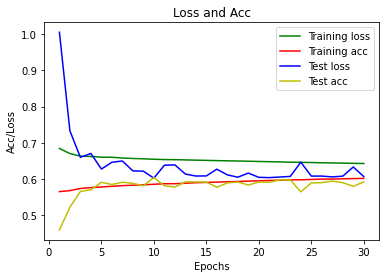

In [144]:
import matplotlib.pyplot as plt
loss = [x[0] for x in history]
acc = [x[1] for x in history]
test_loss = [x[2] for x in history]
test_acc = [x[3] for x in history]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.plot(epochs, test_acc, 'y', label='Test acc')  
plt.title('Loss and Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc/Loss')
plt.legend()
plt.show()

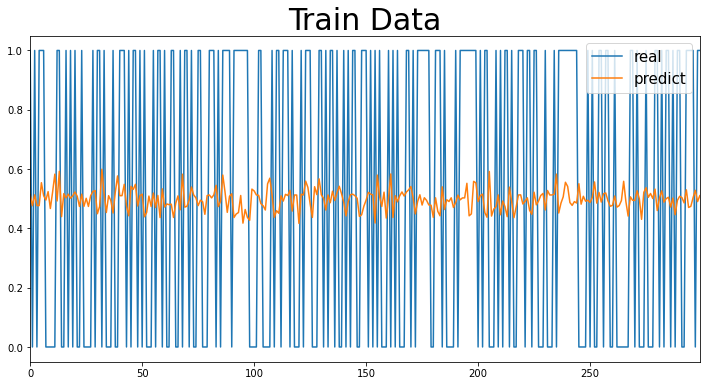

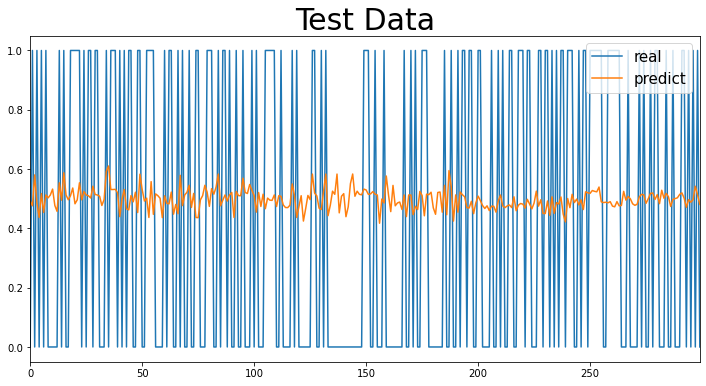

In [ ]:
rnn = rnn.cpu()
Y_train_pred = torch.sigmoid(rnn(torch.from_numpy(X_train).float()).detach()).numpy()

import matplotlib.pyplot as plt

draw=pd.concat([pd.DataFrame(Y_train),pd.DataFrame(Y_train_pred)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30')
plt.show()

Y_test_pred = torch.sigmoid(rnn(torch.from_numpy(X_test).float()).detach()).numpy()

draw=pd.concat([pd.DataFrame(Y_test),pd.DataFrame(Y_test_pred)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30')
plt.show()

In [ ]:
display('Accuracy :', metrics.accuracy_score(Y_test, Y_test_pred.round()))
display('F1-score :', metrics.f1_score(Y_test, Y_test_pred.round()))

NameError: name 'Y_test' is not defined